# Researcher Agent v3 - Refactored

A cleaned and improved version of the research agent workflow that generates blog posts by:
1. Planning sections based on user query
2. Finding relevant web sources for each section
3. Downloading and processing content
4. Generating comprehensive blog post sections


## Configuration and Setup

In [18]:
# Configuration constants
MAX_SOURCES_PER_SECTION = 2
REQUEST_TIMEOUT = 300
CONTEXT_WINDOW = 80000
MODEL_NAME = "qwen2:7b"

In [19]:
# Core imports
import urllib.request
import urllib.error
from typing import TypedDict, Optional, Annotated, List
from datetime import datetime
from bs4 import BeautifulSoup

# LangChain imports
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from llama_index.core.base.llms.types import MessageRole
from llama_index.core.base.llms.base import ChatMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

# LLM imports
from llama_index.llms.ollama import Ollama
from llama_index.core.chat_engine import SimpleChatEngine
from ddgs import DDGS

# Display imports
from IPython.display import Image, display

In [20]:
# Initialize LLM
llm = Ollama(
    model=MODEL_NAME, 
    context_window=CONTEXT_WINDOW, 
    request_timeout=REQUEST_TIMEOUT
)

# Create a ChatEngine
# This engine will automatically manage the conversation history
chat_model = SimpleChatEngine.from_defaults(llm=llm)

# Test connection
test_response = chat_model.chat("Hello")
print(f"Model initialized: {test_response.response[:50]}...")

Model initialized: Hello! How can I assist you today?...


## Utility Functions

In [21]:
def extract_text_from_html(raw_html: str) -> str:
    """
    Extract clean text from raw HTML using BeautifulSoup.
    
    Args:
        raw_html (str): Raw HTML content
        
    Returns:
        str: Extracted clean text
    """
    try:
        soup = BeautifulSoup(raw_html, 'html.parser')
        
        # Remove unwanted elements
        for element in soup(["script", "style", "nav", "footer", "header", "aside"]):
            element.decompose()
        
        # Extract and clean text
        text = soup.get_text()
        
        # Clean whitespace
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        cleaned_text = ' '.join(chunk for chunk in chunks if chunk)
        
        return cleaned_text
    except Exception as e:
        print(f"Error extracting text from HTML: {e}")
        return ""

In [22]:
def parse_sections_list(llm_response: str) -> List[str]:
    """
    Parse LLM response to extract section list.
    
    Args:
        llm_response (str): Raw LLM response containing section list
        
    Returns:
        List[str]: Parsed sections
    """
    try:
        # Remove brackets and split by comma
        cleaned = llm_response.strip().strip('[]')
        sections = [section.strip().strip('"').strip("'") for section in cleaned.split(',')]
        return [section for section in sections if section]
    except Exception as e:
        print(f"Error parsing sections: {e}")
        return []

## State Management

In [23]:
class ResearchState(TypedDict):
    """State for the research workflow."""
    
    # Main query for research
    query: str
    
    # Blog post sections to write
    sections: List[str]
    
    # Current section being processed
    current_section: str
    
    # URLs found for current section
    section_urls: List[str]
    
    # Text content from downloaded URLs
    section_content: List[str]
    
    # Final blog post content
    blog_post: str
    
    # Status flags
    planning_approved: bool
    sources_approved: bool


def create_initial_state(query: str) -> ResearchState:
    """Create initial state for research workflow."""
    return ResearchState(
        query=query,
        messages=[],
        sections=[],
        current_section="",
        section_urls=[],
        section_content=[],
        blog_post="",
        planning_approved=False,
        sources_approved=False
    )

## Workflow Functions

In [24]:
def plan_sections(state: ResearchState) -> ResearchState:
    """
    Generate a plan with sections for the blog post.
    """
    query = state["query"]

    print()
    
    prompt = f"""
    Create a comprehensive outline for a blog post about: {query}
    
    Output ONLY a Python list format like this:
    ["Introduction", "Section 1 Title", "Section 2 Title", "Conclusion"]
    
    Do not include any other text, explanations, or formatting.
    """
    response = chat_model.chat(prompt)
    sections_text = response.response
    
    # Parse sections
    sections = parse_sections_list(sections_text)
    
    # Update state
    state["sections"] = sections
    
    print(f"📋 Planned sections: {sections}")
    return state

In [25]:
def approve_plan(state: ResearchState) -> str:
    """
    Check if the user approves the planning.
    """
    sections = state["sections"]
    print(f"\n📋 Proposed sections: {sections}")
    
    user_input = input("\nApprove this plan? (press Enter to approve, or provide feedback): ")
    
    if user_input.strip():
        # User provided feedback
        human_msg = ChatMessage(
            role=MessageRole.USER,
            content=user_input,
        )
        chat_model.chat_history.append(human_msg)
        return "replan"
    else:
        # User approved
        state["planning_approved"] = True
        return "proceed"

In [26]:
def start_next_section(state: ResearchState) -> ResearchState:
    """
    Start processing the next section.
    """
    if not state["sections"]:
        return state
    
    # Get next section
    current_section = state["sections"].pop(0)
    state["current_section"] = current_section
    
    # Reset section-specific data
    state["section_urls"] = []
    state["section_content"] = []
    state["sources_approved"] = False
    
    print(f"\n📝 Starting section: {current_section}")
    return state

In [27]:
def find_sources(state: ResearchState) -> ResearchState:
    """
    Find relevant web sources for the current section.
    """
    query = state["query"]
    section = state["current_section"]
    
    # Create search query
    search_query = f"{query} {section}"
    
    try:
        # Search for sources
        search_engine = DDGS()
        results = search_engine.text(
            query=search_query, 
            max_results=MAX_SOURCES_PER_SECTION
        )
        
        # Extract URLs
        urls = [result["href"] for result in results]
        state["section_urls"] = urls
        
        print(f"🔍 Found {len(urls)} sources for '{section}'")
        for i, url in enumerate(urls, 1):
            print(f"  {i}. {url}")
            
    except Exception as e:
        print(f"❌ Error finding sources: {e}")
        state["section_urls"] = []
    
    return state

In [28]:
def approve_sources(state: ResearchState) -> str:
    """
    Check if user approves the found sources.
    """
    urls = state["section_urls"]
    
    if not urls:
        print("⚠️ No sources found. Proceeding anyway.")
        return "proceed"
    
    print(f"\n🔍 Found sources:")
    for i, url in enumerate(urls, 1):
        print(f"  {i}. {url}")
    
    user_input = input("\nApprove these sources? (press Enter to approve, or provide alternative search terms): ")
    
    if user_input.strip():
        # User wants different sources
        # Update search query and try again
        try:
            search_engine = DDGS()
            results = search_engine.text(
                query=user_input, 
                max_results=MAX_SOURCES_PER_SECTION
            )
            state["section_urls"] = [result["href"] for result in results]
            return "recheck_sources"
        except Exception as e:
            print(f"❌ Error with new search: {e}")
            return "proceed"
    else:
        state["sources_approved"] = True
        return "proceed"

In [29]:
def download_content(state: ResearchState) -> ResearchState:
    """
    Download and process content from approved sources.
    """
    urls = state["section_urls"]
    content_list = []
    
    for url in urls:
        try:
            print(f"⬇️ Downloading: {url}")
            
            with urllib.request.urlopen(url, timeout=30) as response:
                html_content = response.read()
                text_content = extract_text_from_html(html_content)
                
                if text_content:
                    # Limit content length to avoid token limits
                    content_list.append(text_content[:5000])
                    print(f"✅ Downloaded {len(text_content)} characters")
                else:
                    print(f"⚠️ No content extracted from {url}")
                    
        except urllib.error.URLError as e:
            print(f"❌ URL Error for {url}: {e}")
        except Exception as e:
            print(f"❌ Unexpected error for {url}: {e}")
    
    state["section_content"] = content_list
    print(f"📚 Downloaded content from {len(content_list)} sources")
    
    return state

In [30]:
def generate_section(state: ResearchState) -> ResearchState:
    """
    Generate blog post section based on downloaded content.
    """
    section_title = state["current_section"]
    content_sources = state["section_content"]
    main_query = state["query"]
    
    # Combine all content
    combined_content = "\n\n".join(content_sources)
    
    prompt = f"""
    Write a comprehensive blog post section about "{section_title}" in the context of "{main_query}".
    
    Use the following source material:
    {combined_content}
    
    Requirements:
    - Write in markdown format
    - Include a clear section header
    - Be informative and well-structured
    - Use relevant information from the sources
    - Keep the content engaging and readable
    - Aim for 500 words
    """

    print("Starting to write a section with the prompt:\n", prompt[:500] + prompt[-500:])   
    
    try:
        response = chat_model.chat(prompt)
        section_content = response.response
        
        # Add to blog post
        state["blog_post"] += section_content + "\n\n"
        
        print(f"✅ Generated section: {section_title}")
        print(f"📄 Current blog post length: {len(state['blog_post'])} characters")
        
    except Exception as e:
        print(f"❌ Error generating section: {e}")
        # Add a placeholder section
        state["blog_post"] += f"\n## {section_title}\n\n[Content generation failed]\n\n"
    
    return state

In [31]:
def check_completion(state: ResearchState) -> str:
    """
    Check if there are more sections to process.
    """
    remaining_sections = len(state["sections"])
    
    if remaining_sections > 0:
        print(f"📋 {remaining_sections} sections remaining")
        return "continue"
    else:
        print("✅ All sections completed!")
        return "finish"

## Workflow Graph

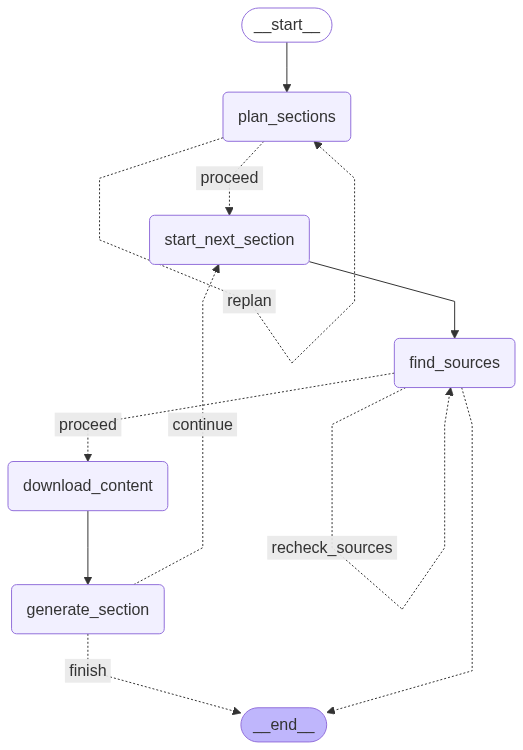

In [32]:
# Create the workflow graph
workflow = StateGraph(ResearchState)

# Add nodes
workflow.add_node("plan_sections", plan_sections)
workflow.add_node("start_next_section", start_next_section)
workflow.add_node("find_sources", find_sources)
workflow.add_node("download_content", download_content)
workflow.add_node("generate_section", generate_section)

# Define edges
workflow.add_edge(START, "plan_sections")

# Conditional edges for plan approval
workflow.add_conditional_edges(
    "plan_sections",
    approve_plan,
    {
        "proceed": "start_next_section",
        "replan": "plan_sections"
    }
)

workflow.add_edge("start_next_section", "find_sources")

# Conditional edges for source approval
workflow.add_conditional_edges(
    "find_sources",
    approve_sources,
    {
        "proceed": "download_content",
        "recheck_sources": "find_sources"
    }
)

workflow.add_edge("download_content", "generate_section")

# Conditional edges for completion check
workflow.add_conditional_edges(
    "generate_section",
    check_completion,
    {
        "continue": "start_next_section",
        "finish": END
    }
)

# Compile the graph
research_graph = workflow.compile()

# Display the graph
display(Image(research_graph.get_graph().draw_mermaid_png()))

## Usage Example

In [33]:
# Example usage
def run_research(topic: str):
    """
    Run the complete research workflow.
    
    Args:
        topic (str): Research topic
    """
    print(f"🚀 Starting research on: {topic}")
    
    # Create initial state
    initial_state = create_initial_state(topic)
    
    # Run the workflow
    final_state = research_graph.invoke(initial_state)
    
    # Save the result
    timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M')
    filename = f"research_output_{timestamp}.md"
    
    with open(filename, "w", encoding="utf-8") as f:
        f.write(f"# {topic}\n\n")
        f.write(final_state["blog_post"])
    
    print(f"\n✅ Research complete! Output saved to: {filename}")
    print(f"📊 Final blog post length: {len(final_state['blog_post'])} characters")
    
    return final_state

In [34]:
# Run the research workflow
# Uncomment and modify the topic as needed

result = run_research("History of Prussia")
print("\n" + "="*50)
print("FINAL BLOG POST:")
print("="*20)
print(result["blog_post"])

🚀 Starting research on: History of Prussia

📋 Planned sections: ['History of Prussia']

📋 Proposed sections: ['History of Prussia']

📝 Starting section: History of Prussia
🔍 Found 2 sources for 'History of Prussia'
  1. https://en.wikipedia.org/wiki/Prussia
  2. https://en.wikipedia.org/wiki/Kingdom_of_Prussia

🔍 Found sources:
  1. https://en.wikipedia.org/wiki/Prussia
  2. https://en.wikipedia.org/wiki/Kingdom_of_Prussia
⬇️ Downloading: https://en.wikipedia.org/wiki/Prussia
✅ Downloaded 84198 characters
⬇️ Downloading: https://en.wikipedia.org/wiki/Kingdom_of_Prussia
✅ Downloaded 68376 characters
📚 Downloaded content from 2 sources
Starting to write a section with the prompt:
 
    Write a comprehensive blog post section about "History of Prussia" in the context of "History of Prussia".

    Use the following source material:
    Prussia - Wikipedia Jump to content From Wikipedia, the free encyclopedia European country, existing from 1525 to 1947 "Prussian" redirects here. For other 